## Detectors

In [52]:
import numpy as np
import pandas as pd

df = pd.read_csv('performance.txt')
df.head(9)

,detector,descriptor,img_id,pts,pts_on_car,matches,detection_time,description_time,total_time,match_dist
0,SHITOMASI,BRISK,1,1301,118,125,18.7433,4.259840,23.0031,73.6480
1,SHITOMASI,BRISK,2,1361,123,118,17.9569,0.393216,18.3501,70.8729
2,SHITOMASI,BRISK,3,1358,120,123,16.3185,0.327680,16.6461,79.5122
3,SHITOMASI,BRISK,4,1333,120,120,16.1219,0.327680,16.4495,73.7000
4,SHITOMASI,BRISK,5,1284,113,120,16.0563,0.327680,16.3840,74.5833
5,SHITOMASI,BRISK,6,1322,114,113,16.0563,0.262144,16.3185,78.2301
6,SHITOMASI,BRISK,7,1366,123,114,17.0394,0.327680,17.3670,68.1228
7,SHITOMASI,BRISK,8,1389,111,123,16.9738,0.327680,17.3015,75.2683
8,SHITOMASI,BRISK,9,1339,112,111,16.1874,0.327680,16.5151,70.3063


The above data reflects all of the metrics used for the evaluation of the best detector/descriptor combination. Lets first take a brief look at different descriptors and their respective properties when averaging their respective statistics (pts, pts_on_car, detection_time)

In [19]:
l = []
p = []

for i in range(0, len(df), 9):
    det = df.iloc[i][0]
    des = df.iloc[i][1]
    
    pts = np.mean([df.iloc[i+j][3] for j in range(0,9)])
    pts_car = np.mean([df.iloc[i+j][4] for j in range(0,9)])
    det_times = np.mean([df.iloc[i+j][6] for j in range(0,9)])
    
    l.append([
        det,pts,pts_car,det_times
    ])
    
for i, line in enumerate(l):
    if len(p) == 0:
        p.append(line)
    else:
        if p[len(p)-1][0] == line[0]:
            continue
        else:
            p.append(line)
    
detectors = pd.DataFrame(p)
detectors.columns = ['detector', 'pts', 'pts_on_car', 'time']
detectors['%_on_car'] = detectors["pts_on_car"] / detectors['pts']
detectors

,detector,pts,pts_on_car,time,%_on_car
0,SHITOMASI,1339.222222,117.111111,16.828200,0.087447
1,HARRIS,180.222222,25.666667,14.898533,0.142417
2,FAST,4904.555556,408.333333,2.133561,0.083256
3,BRISK,2706.555556,277.555556,377.400000,0.102549
4,ORB,500.000000,118.777778,7.616739,0.237556
5,AKAZE,1342.000000,167.111111,71.922100,0.124524
6,SIFT,1380.444444,138.666667,129.637667,0.100451


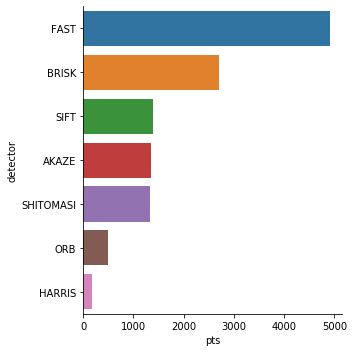

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(y="detector", x="pts", data=detectors.sort_values(['pts'], ascending=False), kind="bar");

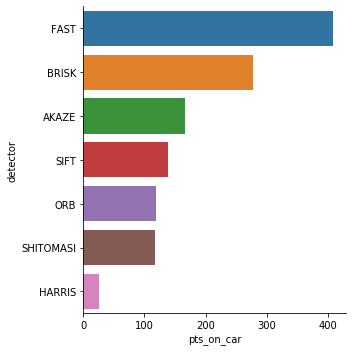

In [35]:
sns.catplot(y="detector", x="pts_on_car", data=detectors.sort_values(['pts_on_car'], ascending=False), kind="bar");

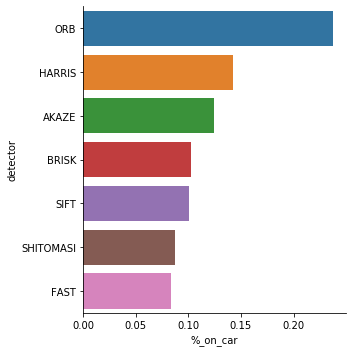

In [36]:
sns.catplot(y="detector", x="%_on_car", data=detectors.sort_values(['%_on_car'], ascending=False), kind="bar");

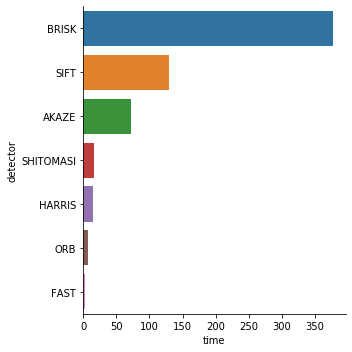

In [37]:
sns.catplot(y="detector", x="time", data=detectors.sort_values(['time'], ascending=False), kind="bar");

Looking at the quick evalution above we can clearly already make a statement on some of the detectors. First of all it can be seen that AKAZE, SIFT and BRISK take way too long in general to be applied in a embedded system on a car with 100ms up to >300ms. Even though their overall performance in locating keypoints on the car seems reasonable seems "middle of the pack", I would assume at this point that ORB and FAST show at least equal performance in terms of being able to locate keypoints at a much faster speed. 

Average Keypoint detections range from around 100 up to 400 for one detector. This seems to be a reasonable number considering the cropped region of interest and the percentage of points on the car. ORB in general detects not many keypoints in the original image but has a really high percentage of detecting them on cars. This may be an advantage of using ORB for car detection, since other keypoints as a road/nature are not that relevant for image processing and are better clustered by using 3D sensors. 

## Describers

When looking at different describers, it is obvious that they are way less time consuming than the detectors. Overall statistics show a median of 0.32 ms, which is really slow. The one outlier with 4ms is actually the first calculation, so my conclusion would be to exclude that from the overall statistic. In general this seems not to be a time consuming task, therefore I would not value the execution time, but rather the robustness of the description and the matching process. 

In [45]:
np.mean(df['description_time'])
df.describe()['description_time']

count    270.000000
mean       0.756334
std        0.817969
min        0.000000
25%        0.262144
50%        0.327680
75%        1.048580
max        4.259840
Name: description_time, dtype: float64

For analysing the robustness, I am filtering the original data to remove BRISK, AKAZE and SIFT. Then I want to calculate the percentage of matched points from 2 observations and also give some insight in the accuracy of the detection by the mean distance between keypoints in image 1 and 2. Lastly we take into account the overall speed of the combination.

In [47]:
l = []

for i in range(0, len(df), 9):
    det = df.iloc[i][0]
    
    if det == "AKAZE" or det == "BRISK" or det == "SIFT":
        continue
    
    des = df.iloc[i][1]
    pts_car = np.mean([df.iloc[i+j][4] for j in range(0,9)])
    matches = np.mean([df.iloc[i+j][5] for j in range(0,9)])
    total_times = np.mean([df.iloc[i+j][8] for j in range(0,9)])
    match_dist = np.mean([df.iloc[i+j][9] for j in range(0,9)])
    
    l.append([
        det,des,pts_car,matches,total_times, match_dist
    ])
    
combs = pd.DataFrame(l)
combs.columns = ['detector', 'descriptor', 'pts_on_car', 'matches', 'time', 'match_dist']
combs['%_matched'] = combs['matches'] / combs['pts_on_car']
combs['comb'] = combs['detector'] + '_' + combs['descriptor']
combs

,detector,descriptor,pts_on_car,matches,time,match_dist,%_matched,comb
0,SHITOMASI,BRISK,117.111111,118.555556,17.592767,73.804878,1.012334,SHITOMASI_BRISK
1,SHITOMASI,BRIEF,117.111111,118.555556,16.762644,16.555767,1.012334,SHITOMASI_BRIEF
2,SHITOMASI,ORB,117.111111,118.555556,16.653422,21.960111,1.012334,SHITOMASI_ORB
3,SHITOMASI,FREAK,117.111111,118.555556,12.495533,60.805056,1.012334,SHITOMASI_FREAK
4,SHITOMASI,SIFT,117.111111,118.555556,12.903300,117.044778,1.012334,SHITOMASI_SIFT
5,HARRIS,BRISK,25.666667,23.777778,15.007744,85.677567,0.926407,HARRIS_BRISK
6,HARRIS,BRIEF,25.666667,23.777778,15.131533,23.319856,0.926407,HARRIS_BRIEF
7,HARRIS,ORB,25.666667,23.777778,14.578133,27.927089,0.926407,HARRIS_ORB
8,HARRIS,FREAK,25.666667,23.777778,14.731044,71.778456,0.926407,HARRIS_FREAK
9,HARRIS,SIFT,25.666667,23.777778,15.881544,126.656856,0.926407,HARRIS_SIFT


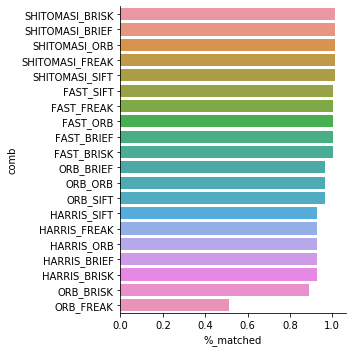

In [49]:
sns.catplot(y="comb", x="%_matched", data=combs.sort_values(['%_matched'], ascending=False), kind="bar");

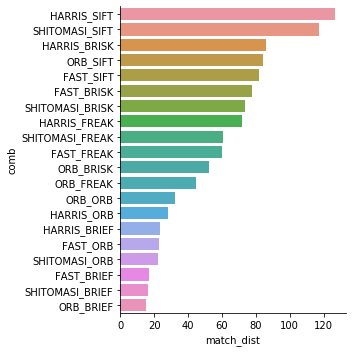

In [50]:
sns.catplot(y="comb", x="match_dist", data=combs.sort_values(['match_dist'], ascending=False), kind="bar");

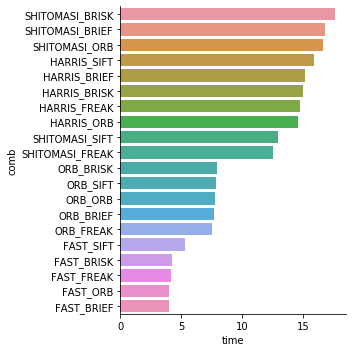

In [51]:
sns.catplot(y="comb", x="time", data=combs.sort_values(['time'], ascending=False), kind="bar");

Overall my recommendation would be to use either one of the following combinations:

- FAST-BRIEF
- FAST-ORB
- ORB-BRIEF

They all feature a comparatively great performance in speed and a really low distance of matched keypoints, which means a high likelyhood that the result will be accurate.  